In [1]:
import numpy as np #pip install kuramoto before running
import matplotlib.pyplot as plt
import networkx as nx #library for complex systems
import seaborn as sns #library to make statistical plots
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from kuramoto import Kuramoto, plot_phase_coherence, plot_activity 

N=np.int(480) #number of oscillators
d=[]

for i in range(1,np.int(N/2+1)): #find the integer divisors of N (except N)
    if N%i==0:
        d.append(i)
    
# Interactions are represented as an adjacency matrix _A_
# Instantiate a random graph 
graph_nx = nx.erdos_renyi_graph(N, p=1) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx) #and transform into an adjacency matrix

#generate a distribution of evenly spaced frequencies in [-gamma,gamma] for gamma=0.2 Hz
gamma=0.2 #Hz
g=np.zeros((len(d),N)) #prepare to store freq distributions for N/2+1 values of M

for M in range(len(d)): #number of groups of oscillators with common natural frequency
    p=np.int(N/d[M]) #number of oscillators in every group with common frequency
    vec=np.array([])
    freq=np.linspace(-gamma,gamma,d[M])
    
    for i in freq:
        sub=np.full(p,i)#define a set of subvectors that will form each row
        vec=np.concatenate((vec,sub))
        
    g[M,:]=vec #store the freq dist in the Mth row
g[0,:]=np.zeros(N)#change the frequency for the M=1 case from -gamma to 0

In [2]:
# Instantiate model with parameters
T=10 #time of observation
dt=0.01 #length of time steps
act_mat=np.zeros((len(d),N,np.int(T/dt)))
for j in range(len(d)):
    #use the freq dist created before
    model = Kuramoto(coupling=1, dt=dt, T=T, n_nodes=len(graph),natfreqs =g[j,:])
    act_mat[j,:,:] = model.run(adj_mat=graph)# output is node vs time


In [3]:
#define the order parameter r(t) from scratch to plot in log scale
time=np.linspace(0,T,np.int(T/dt))
tmax=np.int(250)#fit considering the first tmax time steps
r=np.zeros((len(d),np.int(T/dt)))#prepare to store order parameters for every freq dist
rho=np.zeros(len(d))#to store Pearson coefficient
m=np.zeros(len(d)) #fit slope
q=np.zeros(len(d))
for k in range(len(d)):
    r[k,:]=abs(sum(np.exp(1j*act_mat[k,:,:]))*N**(-1)) #every row considers a different number of groups
    result=linregress(time[0:tmax], np.log(r[k,0:tmax]))#make linear regression on the first tmax time steps
    rho[k]=result.rvalue #r value (Pearson coefficient) of the linear regression 
    m[k]=result.slope
    q[k]=result.intercept

the mean slope is: 0.5035759283631636


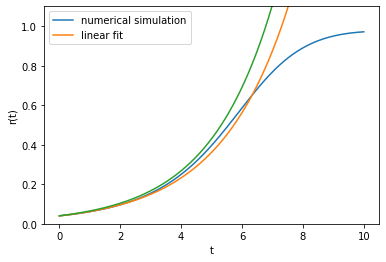

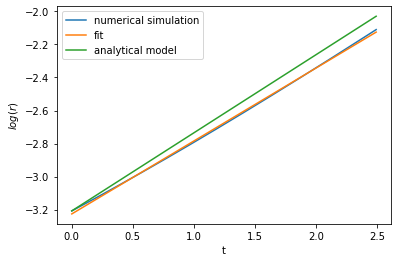

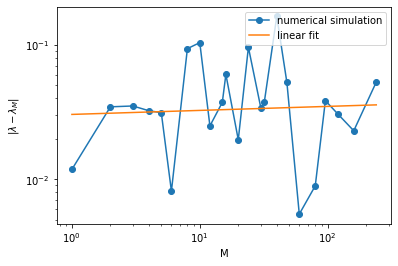

$|\lambda-\lambda_M|$ goes as d^ 0.029837049657697467


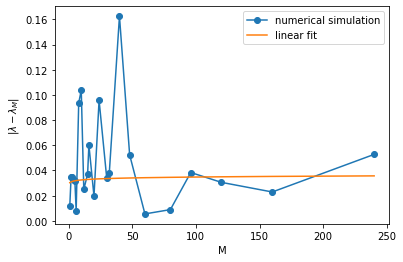

In [14]:
#compare the plots of the simulation, fit and analytical solution for one of the number of groups    
l=0.47304 #slope from analytical model
c=np.int(4) #the element position in d to be shown

print('the mean slope is:',np.mean(m))
plt.plot(time, r[c,:],label='numerical simulation')
plt.plot(time, np.exp(q[c]+m[c]*time),label='linear fit')
plt.plot(time,r[c,0]*np.exp(l*time))
plt.ylim((0,1.1))
plt.xlabel('t')
plt.ylabel('r(t)')
plt.legend()
plt.show()
plt.plot(time[0:tmax], np.log(r[c,0:tmax]),label='numerical simulation')    
plt.plot(time[0:tmax], q[c]+m[c]*time[0:tmax], label='fit')
plt.plot(time[0:tmax], np.log(r[c,0])+l*time[0:tmax], label='analytical model')
plt.xlabel('t')
plt.ylabel(r'$log(r)$')
plt.legend()
plt.show()

#plt.plot(d, rho, marker='o', linestyle='--')#plot number of groups d vs rvalues
#plt.xlabel('number of groups')
#plt.ylabel('r value')
#plt.show()
#make a lin. reg. to find a pattern of dependency on M of the discrepancy with the analytical model 
reg=linregress(np.log(d),np.log(np.abs(l-m)))
pattern=np.exp(reg.intercept)*np.power(d,reg.slope)#
plt.loglog(d,np.abs(l-m), marker='o', label='numerical simulation')
plt.loglog(d, pattern, label='linear fit')
plt.ylabel(r'$|\lambda-\lambda_M|$')
plt.xlabel('M')
plt.legend()
plt.show()
#now in linear scale
plt.plot(d,np.abs(l-m), marker='o',label='numerical simulation')
plt.plot(d,pattern, label='linear fit')
plt.xlabel('M')
plt.ylabel(r'$|\lambda-\lambda_M|$')
plt.legend()
print(r'$|\lambda-\lambda_M|$ goes as d^', reg.slope)